## Stock Price prediction
##### Predicting the future prices as well

In [1]:
### importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### setting up the system path and taking the functions from the src
import sys
sys.path.append('../')
from src.graphs.graphs_metrices import metrices, plot_predictions, plot_graphs_post_scaling

In [3]:
### loading the dataset (Apple stock price as of 18-02)
df = pd.read_csv('../stocks/apple-18-2.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2021-02-19 00:00:00+00:00,129.87,130.7100,128.80,130.24,87668834,126.505301,127.323538,125.463023,126.865715,87668834,0.0,1.0
1,AAPL,2021-02-22 00:00:00+00:00,126.00,129.7200,125.60,128.01,102886922,122.735566,126.359187,122.345929,124.693491,102886922,0.0,1.0
2,AAPL,2021-02-23 00:00:00+00:00,125.86,126.7100,118.39,123.76,158273022,122.599193,123.427171,115.322727,120.553600,158273022,0.0,1.0
3,AAPL,2021-02-24 00:00:00+00:00,125.35,125.5600,122.23,124.94,111039904,122.102406,122.306966,119.063240,121.703029,111039904,0.0,1.0
4,AAPL,2021-02-25 00:00:00+00:00,120.99,126.4585,120.54,124.68,144766924,117.855366,123.182187,117.417025,121.449765,144766924,0.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1255 non-null   object 
 1   date         1255 non-null   object 
 2   close        1255 non-null   float64
 3   high         1255 non-null   float64
 4   low          1255 non-null   float64
 5   open         1255 non-null   float64
 6   volume       1255 non-null   int64  
 7   adjClose     1255 non-null   float64
 8   adjHigh      1255 non-null   float64
 9   adjLow       1255 non-null   float64
 10  adjOpen      1255 non-null   float64
 11  adjVolume    1255 non-null   int64  
 12  divCash      1255 non-null   float64
 13  splitFactor  1255 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.4+ KB


In [5]:
df['date'] = df['date'].astype('date64[pyarrow]')

In [6]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2021-02-19,129.87,130.7100,128.80,130.24,87668834,126.505301,127.323538,125.463023,126.865715,87668834,0.0,1.0
1,AAPL,2021-02-22,126.00,129.7200,125.60,128.01,102886922,122.735566,126.359187,122.345929,124.693491,102886922,0.0,1.0
2,AAPL,2021-02-23,125.86,126.7100,118.39,123.76,158273022,122.599193,123.427171,115.322727,120.553600,158273022,0.0,1.0
3,AAPL,2021-02-24,125.35,125.5600,122.23,124.94,111039904,122.102406,122.306966,119.063240,121.703029,111039904,0.0,1.0
4,AAPL,2021-02-25,120.99,126.4585,120.54,124.68,144766924,117.855366,123.182187,117.417025,121.449765,144766924,0.0,1.0


In [7]:
### targeting the 'close' feature only
df_closing_price = df[['close']].values
df_closing_price

array([[129.87],
       [126.  ],
       [125.86],
       ...,
       [255.78],
       [263.88],
       [264.35]])

In [8]:
### checking the shape of the df_closing_price
df_closing_price.shape

(1255, 1)

In [9]:
### cling the data using the minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df_closing_price = scaler.fit_transform(df_closing_price)
df_closing_price

array([[0.07955014],
       [0.05676264],
       [0.05593829],
       ...,
       [0.82093859],
       [0.86863334],
       [0.87140081]])

In [10]:
### checking it's shape again
df_closing_price.shape

(1255, 1)

In [11]:
### making the sequences
X, y = [], []
days = 90

for i in range(len(df_closing_price) - days) : 

    X.append(df_closing_price[i : i + days])
    y.append(df_closing_price[i + days])

X = np.array(X)
y = np.array(y)

In [12]:
### checking the shape of X and y
print(f"{X.shape} :: {y.shape}")

(1165, 90, 1) :: (1165, 1)


In [13]:
### making the train and test sequences
test_size = int(len(df_closing_price) * 0.80)
X_train, X_test = X[:test_size], X[test_size:]
y_train, y_test = y[:test_size], y[test_size:]

In [14]:
### checking the shape of the train and the test sequences
print(f"{X_train.shape} :: {y_train.shape} \n{X_test.shape} :: {y_test.shape}")

(1004, 90, 1) :: (1004, 1) 
(161, 90, 1) :: (161, 1)


In [15]:
### importing the Keras libraries for the LSTM model
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional

In [16]:
### making the model
model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (days, 1)),
    Dropout(0.33),
    Bidirectional(LSTM(100)),
    Dropout(0.33),
    Dense(1, activation = 'linear')
])
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])

c:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
### checking the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,401 (513.29 KB)

 Trainable params: 131,401 (513.29 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
### training the model
model.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0895 - mse: 0.0895
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0086 - mse: 0.0086
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0052 - mse: 0.0052
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0042 - mse: 0.0042
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039 - mse: 0.0039
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0030 - mse: 0.0030
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0033 - mse: 0.0033
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0033 - mse: 0.0033
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0031 - mse: 0.0031
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0030 - mse: 0.0030
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0031 - mse: 0.0031
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0028 - mse: 0.0028
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━

In [19]:
### predictions on the X_test
y_pred = model.predict(X_test)
y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


array([[0.50924057],
       [0.51396   ],
       [0.5209646 ],
       [0.5315371 ],
       [0.54361194],
       [0.55285245],
       [0.55967724],
       [0.5648792 ],
       [0.5688801 ],
       [0.57115525],
       [0.57043564],
       [0.5681798 ],
       [0.56578517],
       [0.56305385],
       [0.5617896 ],
       [0.56231034],
       [0.5650618 ],
       [0.5689972 ],
       [0.5725452 ],
       [0.57564485],
       [0.5783574 ],
       [0.5785858 ],
       [0.5760914 ],
       [0.57107145],
       [0.56177014],
       [0.551484  ],
       [0.54162073],
       [0.5394341 ],
       [0.54676193],
       [0.5645338 ],
       [0.5849322 ],
       [0.6058313 ],
       [0.62788576],
       [0.6477168 ],
       [0.66309375],
       [0.67402107],
       [0.6790961 ],
       [0.6784002 ],
       [0.67308044],
       [0.6675466 ],
       [0.6622372 ],
       [0.65965   ],
       [0.659451  ],
       [0.6625106 ],
       [0.6664666 ],
       [0.6688634 ],
       [0.6759087 ],
       [0.685

In [20]:
### checking the y_pred shape
y_pred.shape

(161, 1)

In [21]:
### using the inverse scaler for the metrics and plotting
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [22]:
### for the comparison plotting the graphs and the metrices
metrices(y_test, y_pred)

MAE : 5.2734619140625005
MSE : 47.28683590138695
RMSE : 6.87654243798342


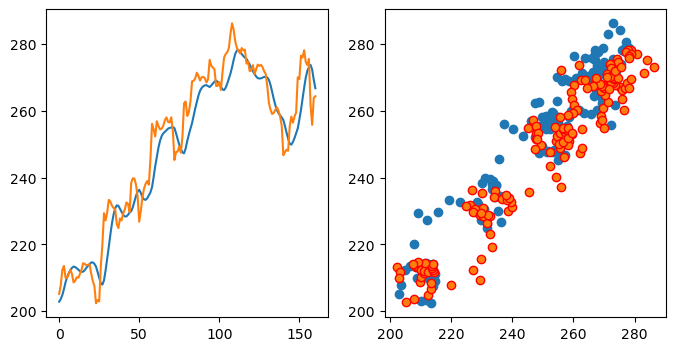

In [23]:
### plotting out the things
plot_predictions(y_test, y_pred)

In [19]:
### predictions on the next 90 days price
### for the prediction of the future prices : 
### we need the last window, predict and then use the sliding window forward

In [20]:
### getting the last sequence
window_size = 90
last_sequence = df_closing_price[-window_size:]
last_sequence

array([[0.81069305],
       [0.75905317],
       [0.77312607],
       [0.77377377],
       [0.78301831],
       [0.77188954],
       [0.80038862],
       [0.85897662],
       [0.86209739],
       [0.83666019],
       [0.8433139 ],
       [0.8623918 ],
       [0.89766237],
       [0.89878113],
       [0.9029029 ],
       [0.91291291],
       [0.90684802],
       [0.89907555],
       [0.9049049 ],
       [0.90549373],
       [0.90331508],
       [0.89566037],
       [0.90131308],
       [0.93558264],
       [0.92510157],
       [0.92203969],
       [0.91886004],
       [0.88971324],
       [0.88959548],
       [0.89619031],
       [0.88258847],
       [0.91344285],
       [0.93952776],
       [0.94571042],
       [0.9491256 ],
       [0.95678031],
       [0.98180533],
       [1.        ],
       [0.98798799],
       [0.96767356],
       [0.95636813],
       [0.9511276 ],
       [0.94694695],
       [0.95636813],
       [0.95195195],
       [0.95342401],
       [0.92887005],
       [0.931

In [21]:
### checking out the shape
last_sequence.shape

(90, 1)

In [22]:
### reshaping it
last_sequence = last_sequence.reshape(1, window_size, 1)
last_sequence.shape

(1, 90, 1)

In [23]:
### predicting the next days and moving the window forward
future_days = 120
future_pred = []
current_window = last_sequence.copy()

for _ in range(future_days) : 

    next_pred = model.predict(current_window, verbose = 0)

    future_pred.append(next_pred[0, 0])

    next_pred_reshaped = next_pred.reshape(1, 1, 1)

    current_window = np.concatenate(
    (current_window[:, 1:, :], next_pred_reshaped),
    axis=1
    )

In [24]:
### checking out the future predictions
future_pred

[0.8435877,
 0.8327463,
 0.8229211,
 0.8137317,
 0.8052334,
 0.7973741,
 0.79025847,
 0.7836517,
 0.77732486,
 0.7714965,
 0.76628095,
 0.76148534,
 0.75700027,
 0.75267524,
 0.74862754,
 0.74479437,
 0.741104,
 0.7376113,
 0.73431057,
 0.73111856,
 0.72805154,
 0.7251152,
 0.7223381,
 0.71964455,
 0.7168564,
 0.71418655,
 0.7115917,
 0.709082,
 0.7068213,
 0.7046939,
 0.70268804,
 0.7009335,
 0.69920087,
 0.6974915,
 0.69588435,
 0.69437283,
 0.6929126,
 0.69137466,
 0.68975085,
 0.688169,
 0.6866692,
 0.685214,
 0.6837787,
 0.68236077,
 0.6808824,
 0.6794071,
 0.6778992,
 0.676503,
 0.67508596,
 0.67376214,
 0.6724434,
 0.6710929,
 0.66983753,
 0.6685466,
 0.6671983,
 0.66582805,
 0.66439104,
 0.6628986,
 0.6613538,
 0.6597381,
 0.658146,
 0.6566376,
 0.6551522,
 0.6536854,
 0.6521926,
 0.6506511,
 0.6490508,
 0.64744514,
 0.64586365,
 0.64436376,
 0.64319575,
 0.6421192,
 0.6411828,
 0.64044785,
 0.63968,
 0.6390046,
 0.6385696,
 0.63826615,
 0.6381079,
 0.6377576,
 0.6375027,
 0.63

In [26]:
### checking out the future pred shape
len(future_pred)

120

In [27]:
### coverting it to the array
future_pred = np.array(future_pred).reshape(-1, 1)
future_pred

array([[0.8435877 ],
       [0.8327463 ],
       [0.8229211 ],
       [0.8137317 ],
       [0.8052334 ],
       [0.7973741 ],
       [0.79025847],
       [0.7836517 ],
       [0.77732486],
       [0.7714965 ],
       [0.76628095],
       [0.76148534],
       [0.75700027],
       [0.75267524],
       [0.74862754],
       [0.74479437],
       [0.741104  ],
       [0.7376113 ],
       [0.73431057],
       [0.73111856],
       [0.72805154],
       [0.7251152 ],
       [0.7223381 ],
       [0.71964455],
       [0.7168564 ],
       [0.71418655],
       [0.7115917 ],
       [0.709082  ],
       [0.7068213 ],
       [0.7046939 ],
       [0.70268804],
       [0.7009335 ],
       [0.69920087],
       [0.6974915 ],
       [0.69588435],
       [0.69437283],
       [0.6929126 ],
       [0.69137466],
       [0.68975085],
       [0.688169  ],
       [0.6866692 ],
       [0.685214  ],
       [0.6837787 ],
       [0.68236077],
       [0.6808824 ],
       [0.6794071 ],
       [0.6778992 ],
       [0.676

In [28]:
### inverse scaling the things
future_pred = scaler.inverse_transform(future_pred)
future_pred.shape

(120, 1)

In [29]:
### checking out the future pred
future_pred

array([[259.6265 ],
       [257.7853 ],
       [256.11667],
       [254.55605],
       [253.11278],
       [251.77805],
       [250.56958],
       [249.44757],
       [248.37308],
       [247.38324],
       [246.49748],
       [245.68306],
       [244.92134],
       [244.18683],
       [243.49942],
       [242.84843],
       [242.2217 ],
       [241.62852],
       [241.06795],
       [240.52586],
       [240.00499],
       [239.50632],
       [239.03468],
       [238.57724],
       [238.10371],
       [237.6503 ],
       [237.20963],
       [236.7834 ],
       [236.39946],
       [236.03816],
       [235.6975 ],
       [235.39954],
       [235.10529],
       [234.81499],
       [234.54204],
       [234.28532],
       [234.03734],
       [233.77615],
       [233.50038],
       [233.23174],
       [232.97702],
       [232.72989],
       [232.48613],
       [232.24533],
       [231.99425],
       [231.74371],
       [231.48761],
       [231.25049],
       [231.00984],
       [230.78502],


In [49]:
### creating the future date index
last_date = df['date'].iloc[-1]

future_dates = pd.date_range(
    start = last_date + pd.Timedelta(days=1),
    periods = future_days,
    freq='B'   # business days # for the regular days = 'D'
)

future_dates

DatetimeIndex(['2026-02-19', '2026-02-20', '2026-02-23', '2026-02-24',
               '2026-02-25', '2026-02-26', '2026-02-27', '2026-03-02',
               '2026-03-03', '2026-03-04',
               ...
               '2026-07-23', '2026-07-24', '2026-07-27', '2026-07-28',
               '2026-07-29', '2026-07-30', '2026-07-31', '2026-08-03',
               '2026-08-04', '2026-08-05'],
              dtype='datetime64[ns]', length=120, freq='B')

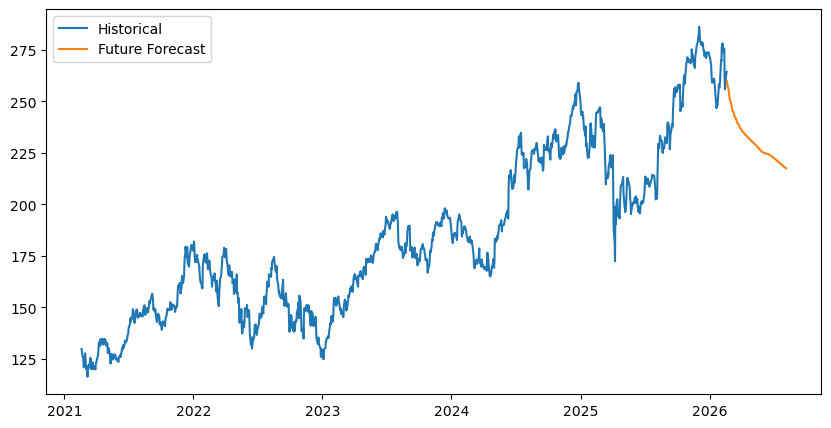

In [52]:
### plotting the graph for the future prices
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['close'], label="Historical")
plt.plot(future_dates, future_pred, label="Future Forecast")
plt.legend()
plt.show()